##### Config

In [1]:
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Disable annoying font warnings
matplotlib.font_manager._log.setLevel(50)

# Disable theano deprecation warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='theano')

# Style
plt.style.use('default')
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['font.size'] = 14
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Liberation Sans']
plt.rcParams['font.cursive'] = ['Liberation Sans']
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.fallback_to_cm'] = True

In [4]:
del matplotlib; del plt; del warnings

##### Main

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.special import factorial
import george
from george.kernels import CosineKernel

In [6]:
def g(n):
    if n % 2 == 0:
        return factorial(n) / (2 ** (n // 2) * factorial(n // 2))
    else:
        return 0


def norm_cov(mu, Sig, N=20):
    K = Sig.shape[0]
    J = np.ones((K, K))
    barSig = np.mean(Sig)

    # Powers of S
    S = (Sig @ J) / K ** 2
    Spow = [np.eye(K)]
    for n in range((N + 2) // 2):
        Spow.append(Spow[-1] @ S)

    norm_cov = np.zeros_like(Sig)
    for n in range(0, N + 1, 2):

        EP = (n + 1) * g(n) * barSig ** ((n + 2) // 2) * J
        P = (-1) ** n * (n + 1) * EP

        EQ = (n + 1) * K * g(n) * Spow[(n + 2) // 2]
        Q = (-1) ** n * (n + 1) * EQ

        ER = n * g(n) * Spow[n // 2] @ Sig + g(n) * barSig ** (n // 2) * Sig
        R = (-1) ** n * (n + 1) * ER

        norm_cov += (P - (Q + Q.T) + R) / (mu ** (n + 2))

    return norm_cov

In [7]:
# GP Mean
mu = 0.5

# GP Amplitude
std = 0.1

# Asymmetry term
offset = 0.5

# Dimension
K = 1000

# Number of samples in numerical estimate
M = 100000

# Expansion order in our series solution
N = 20

In [8]:
# Get the covariance matrix
t = np.linspace(0, 1, K)
kernel = std ** 2 * (offset + CosineKernel(0))
gp = george.GP(kernel)
gp.compute(t)
Sigma = gp.get_matrix(t)

In [9]:
# Draw `M` samples, normalize them,
# and compute the covariance
x = mu + gp.sample(size=M)
mean = np.mean(x, axis=1)[:, None]
xnorm = x / mean
Sigma_norm_num = np.cov(xnorm.T)

In [10]:
# Compute the normalized covariance using the series expansion
Sigma_norm_series = norm_cov(mu, Sigma, N=N)

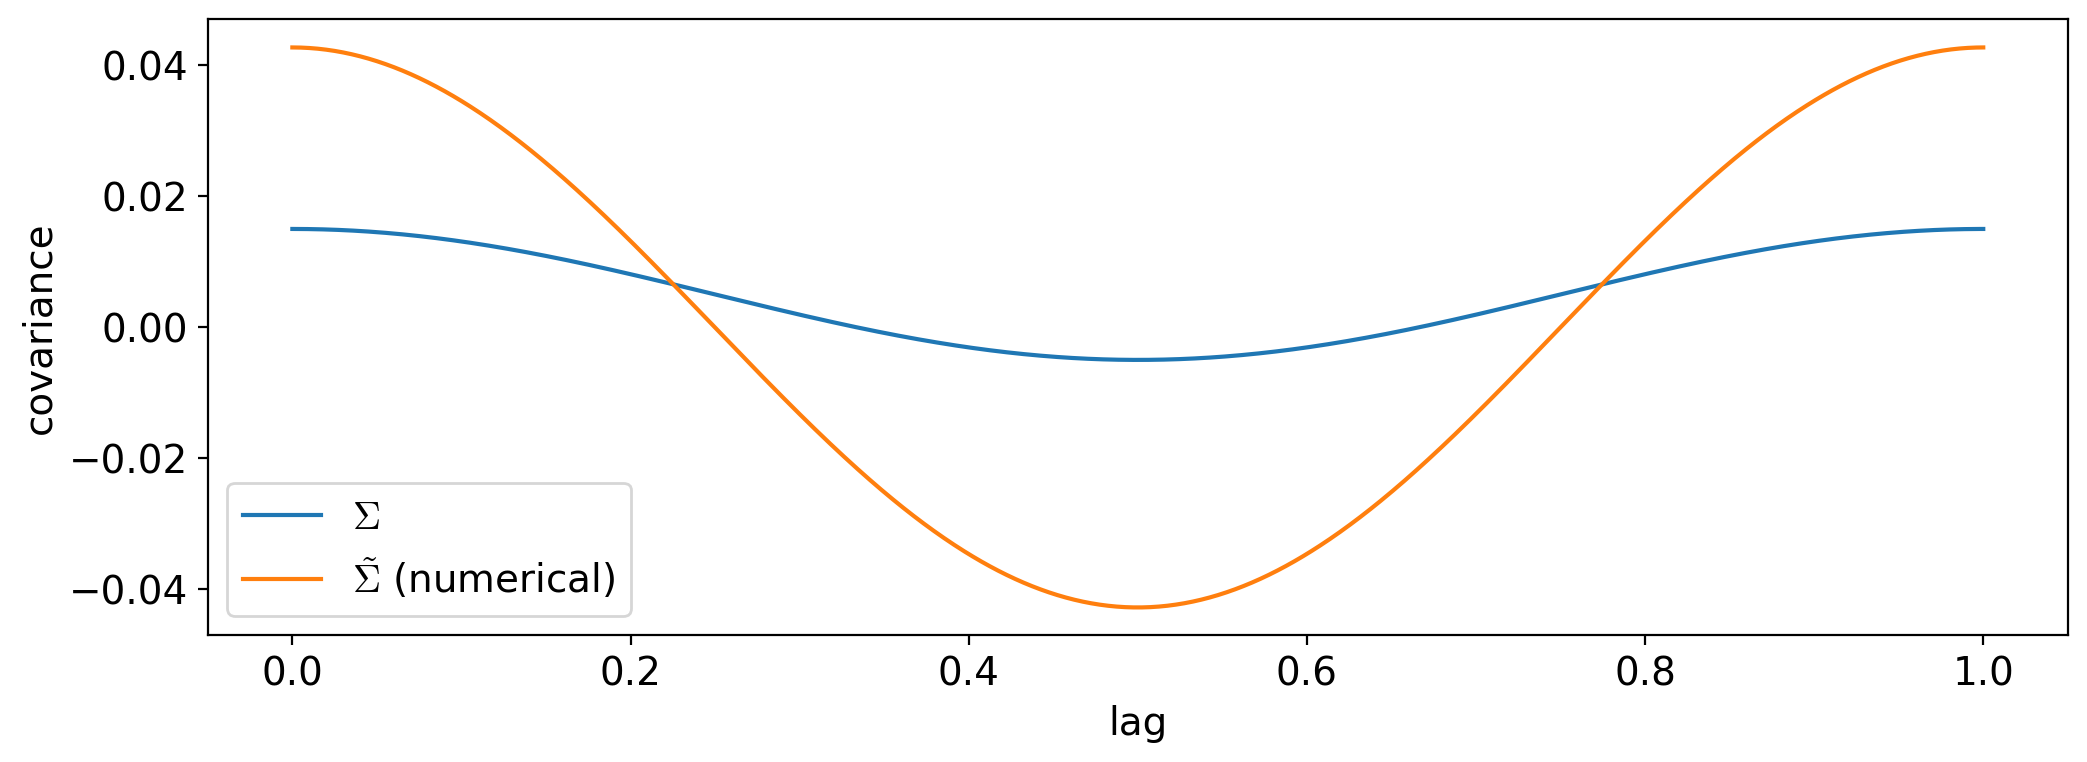

In [11]:
# Plot the original covariance and the numerical normalized covariance
plt.plot(t, Sigma[0], label=r"$\Sigma$")
plt.plot(t, Sigma_norm_num[0], label=r"$\tilde{\Sigma}$ (numerical)")
plt.legend()
plt.xlabel("lag")
plt.ylabel("covariance");

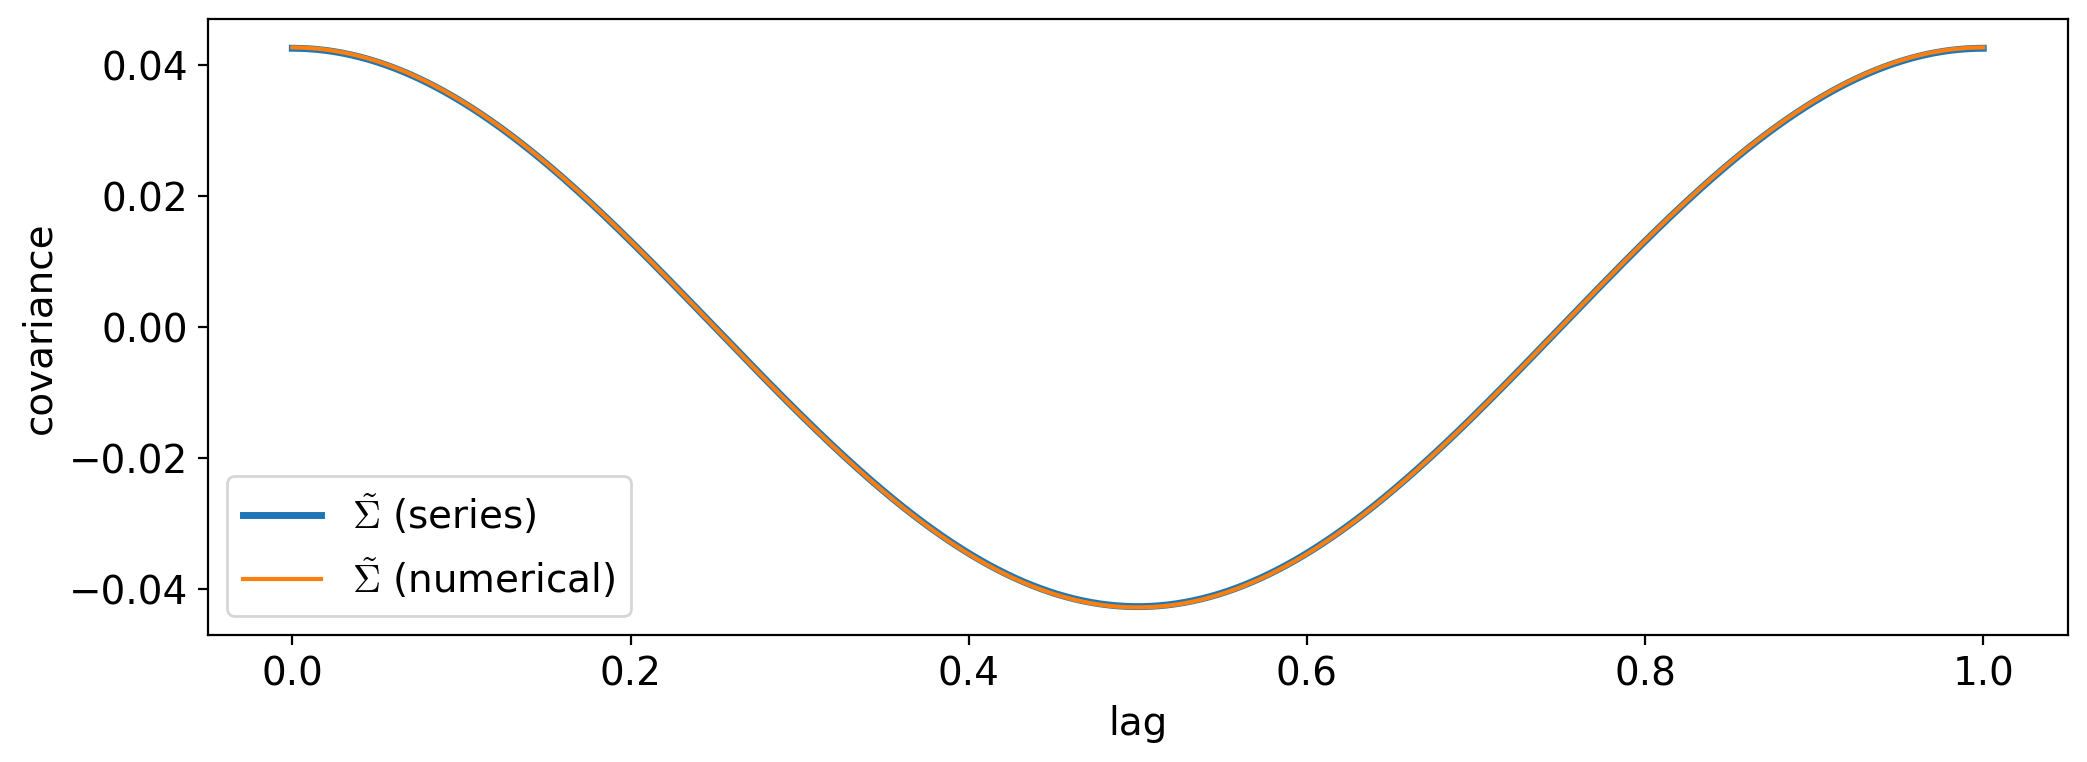

In [12]:
# Plot the series solution and the numerical solution
plt.plot(t, Sigma_norm_series[0], label=r"$\tilde{\Sigma}$ (series)", lw=2.5)
plt.plot(t, Sigma_norm_num[0], label=r"$\tilde{\Sigma}$ (numerical)")
plt.legend()
plt.xlabel("lag")
plt.ylabel("covariance");

In [211]:
%%timeit
norm_cov(mu, Sigma, N=20)

414 ms ± 19.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [212]:
%%timeit
norm_cov(mu, Sigma, N=10)

242 ms ± 17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
